## Load libraries

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import h5py
from sklearn.metrics import classification_report

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.mnist import MNISTDataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model import RickAndMorty
from alphai_rickandmorty_oracle.architecture.mnist import MNISTGanArchitecture

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%matplotlib inline


/home/gmariotti/miniconda3/envs/rickmorty/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
DEBUG:matplotlib:CACHEDIR=/home/gmariotti/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/gmariotti/.cache/matplotlib/fontlist-v300.json
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.


Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DEFAULT_FIT_EPOCHS: 1000
	DEFAULT_LEARN_RATE: 0.0001
	DEFAULT_TRAIN_ITERS: 5000
	DEFAULT_Z_DIM: 200
	DIAGNOSIS_LEARN_RATE: 0.01


## Define MNIST Datasource

In [2]:
file_path = '../../tests/resources'

abnormal_digit = 0

# Train and test data file
train_data_file = os.path.join(file_path, 'mnist_data_train_abnormalclass-{}.hd5'.format(abnormal_digit))
test_data_file = os.path.join(file_path, 'mnist_data_test_abnormalclass-{}.hd5'.format(abnormal_digit))

# Model parameters
n_sensors = 28
n_timesteps = 784 // n_sensors

train_data_source = MNISTDataSource(source_file=train_data_file, 
                                    transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                                number_of_sensors=n_sensors))
test_data_source = MNISTDataSource(source_file=test_data_file,
                                   transformer=NullTransformer(number_of_timesteps=n_timesteps,
                                                               number_of_sensors=n_sensors))

train_data = train_data_source.get_train_data('NORMAL')

### Plot input images to verify correctness

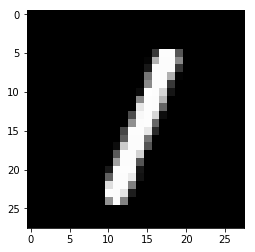

In [3]:
# First row is first image
image = train_data.data[np.random.randint(0, len(train_data.data))]

# h_train = h5py.File(test_data_file)
# image = np.array(h_train.get('ABNORMAL'))[156]

# Plot the image
plt.imshow(np.reshape(image, (28, 28)), cmap='gray')
plt.show()

## Define Model & Train

In [4]:
model_dir = './mnist_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

batch_size = 64
output_dimensions = 784
plot_dimensions = (28, 28)
train_iters = 10000
plot_save_path = model_dir

architecture = MNISTGanArchitecture(output_dimensions, plot_dimensions)

model = RickAndMorty(architecture=architecture,
                     batch_size=batch_size,
                     train_iters=train_iters,
                     plot_save_path=plot_save_path)

detective = RickAndMortyDetective(
    model_configuration = {
        'model': model,
        'output_dimensions': output_dimensions,
        'batch_size': batch_size,
        'train_iters': train_iters,
        'save_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
        'plot_save_path' : plot_save_path
    }
)

iter 0	train disc cost	1.3751428127288818	time	0.6909897327423096
iter 1	train gen cost	0.6419944763183594	train disc cost	1.3431909084320068	time	0.13040447235107422
iter 2	train gen cost	0.6153756380081177	train disc cost	1.326183795928955	time	0.06648468971252441
iter 3	train gen cost	0.6100642085075378	train disc cost	1.2943651676177979	time	0.06922602653503418
iter 4	train gen cost	0.6011046171188354	train disc cost	1.277533769607544	time	0.06501984596252441
iter 99	train gen cost	2.631345272064209	train disc cost	0.32897669076919556	time	0.06225355800829436
iter 199	train gen cost	7.459348201751709	train disc cost	0.0023350738920271397	time	0.056357581615447995
iter 299	train gen cost	10.865082740783691	train disc cost	6.108445813879371e-05	time	0.05880887031555176
iter 399	train gen cost	12.006523132324219	train disc cost	2.03449835680658e-05	time	0.05873287200927734
iter 499	train gen cost	11.968951225280762	train disc cost	1.7592466974747367e-05	time	0.05522946357727051
iter 5

iter 7499	train gen cost	3.0028271675109863	train disc cost	0.319838285446167	time	0.0596555757522583
iter 7599	train gen cost	3.069523572921753	train disc cost	0.31413352489471436	time	0.05534734487533569
iter 7699	train gen cost	3.072836399078369	train disc cost	0.3034611642360687	time	0.05903321743011475
iter 7799	train gen cost	3.143021821975708	train disc cost	0.31345120072364807	time	0.05813110589981079
iter 7899	train gen cost	3.109011173248291	train disc cost	0.3134695887565613	time	0.055539891719818116
iter 7999	train gen cost	3.1694138050079346	train disc cost	0.28319117426872253	time	0.059670839309692386
iter 8099	train gen cost	3.1751549243927	train disc cost	0.2839883863925934	time	0.05711817264556885
iter 8199	train gen cost	3.1533689498901367	train disc cost	0.277668833732605	time	0.0562459397315979
iter 8299	train gen cost	3.2965195178985596	train disc cost	0.2793961465358734	time	0.060131676197052
iter 8399	train gen cost	3.2784786224365234	train disc cost	0.2725038826

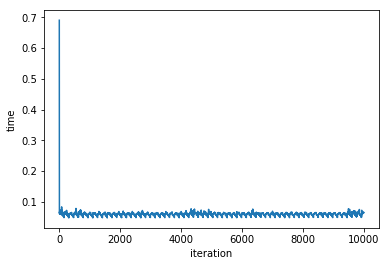

In [5]:
detective.train(train_data)

## Evaluate Results

### Load trained model

In [ ]:
# detective = RickAndMortyDetective(model_configuration={
#     'model': model,
#     'output_dimensions': output_dimensions,
#     'batch_size': batch_size,
#     'train_iters': train_iters,
#     'load_path' : '{}/MNIST-abnormalclass-{}'.format(model_dir, abnormal_digit),
#     'plot_save_path' : plot_save_path
# })

### Visualise generated samples

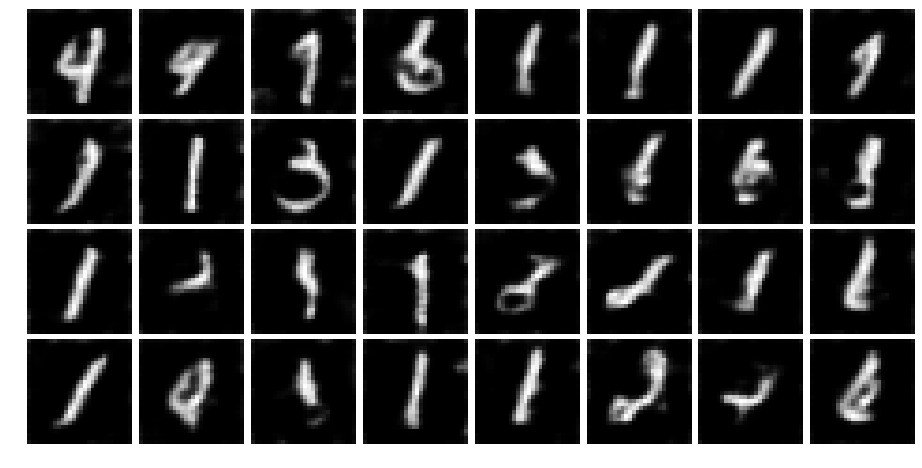

In [6]:
n_row = 4
n_col = 8

plt.figure(figsize=(2*n_col, 2*n_row))

gs = gridspec.GridSpec(n_row, n_col)
gs.update(wspace=0.025, hspace=0.05)

generated_samples = detective.model.generate_fake_samples()

for i in range(n_row * n_col):
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.imshow(generated_samples[i], cmap='gray')

### Load test data

In [7]:
# Get test data
test_data_normal = test_data_source.get_train_data('NORMAL')
test_data_abnormal = test_data_source.get_train_data('ABNORMAL')
test_data = test_data_source.get_train_data('ALL')

# Ground truth for ABNORMAL data is 0, ground truth for NORMAL data is 1
n1 = np.zeros(len(test_data_abnormal.data))
n2 = np.ones(len(test_data_normal.data))
expected_truth = np.hstack((n1, n2))

### Calculate ROC Score

In [8]:
detection_result = detective.detect(test_data)

roc_score = GANPerformanceAnalysis({}).analyse(
  detection_result=detection_result.data,
  expected_truth=expected_truth
)

print('ROC Score: {}'.format(roc_score))

ROC Score: 0.6657509034520236


### Generate classification report

In [9]:
train_results = detective.detect(train_data).data
threshold = np.mean(train_results)
prediction = [1 if x >= threshold else 0 for x in detection_result.data]

target_names = ['ABNORMAL', 'NORMAL']
print(classification_report(expected_truth, prediction, target_names=target_names))

              precision    recall  f1-score   support

    ABNORMAL       0.48      0.60      0.53      6903
      NORMAL       0.75      0.64      0.69     12620

   micro avg       0.63      0.63      0.63     19523
   macro avg       0.61      0.62      0.61     19523
weighted avg       0.65      0.63      0.63     19523



## Root Cause Analysis

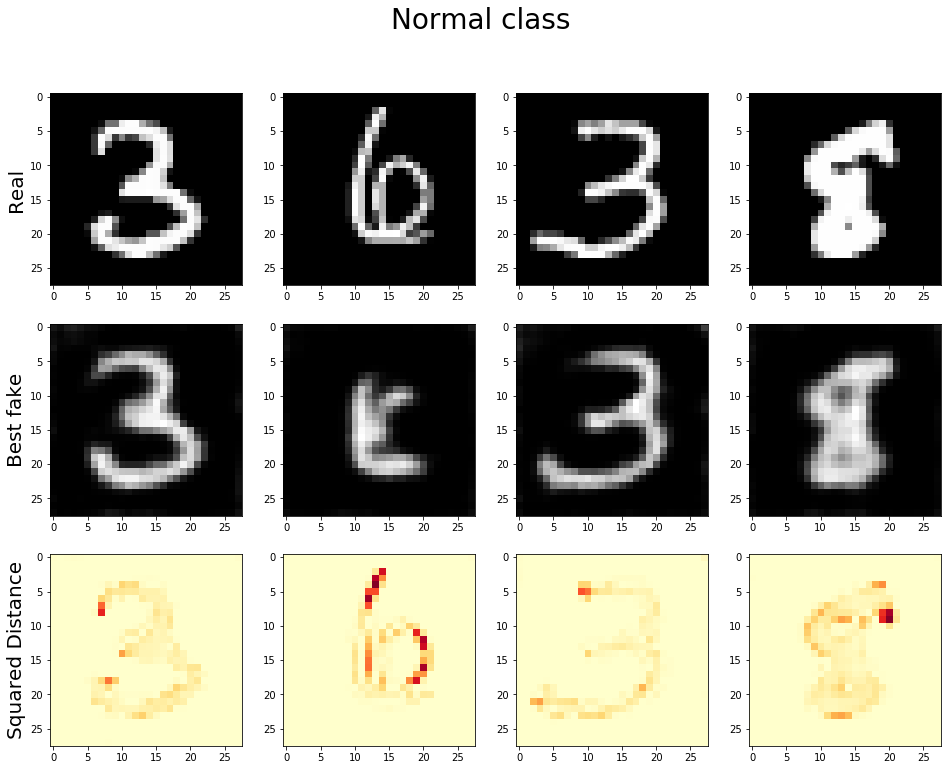

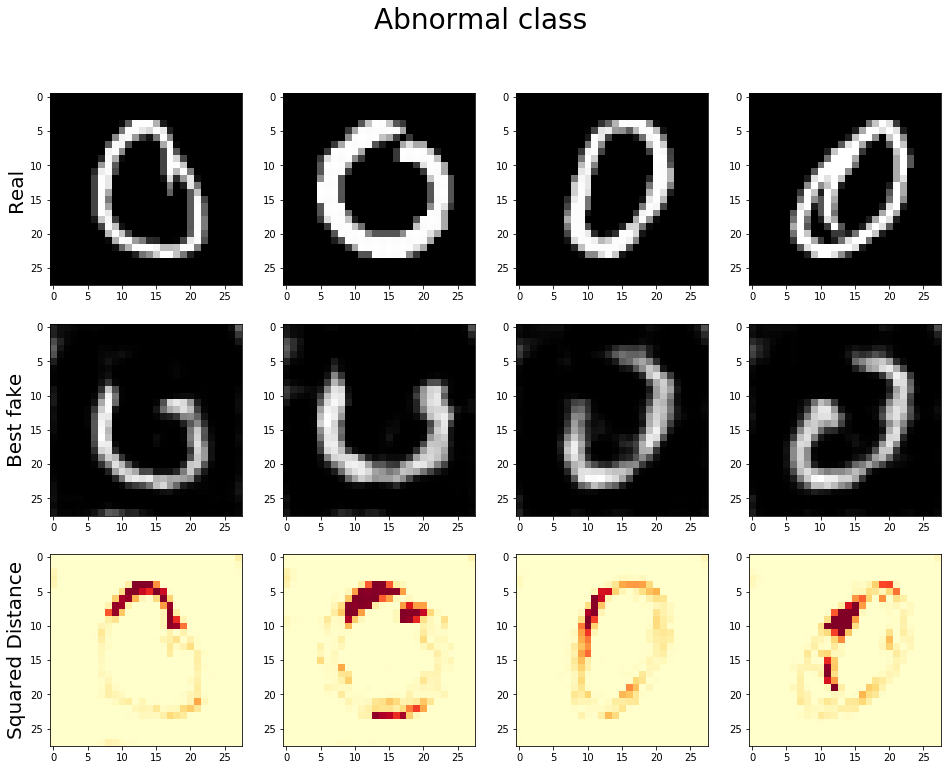

In [10]:
n_img = 4

normal_test_images = \
    test_data_normal.data[np.random.choice(test_data_normal.data.shape[0], n_img, replace=False), :, :]
abnormal_test_images = \
    test_data_abnormal.data[np.random.choice(test_data_abnormal.data.shape[0], n_img, replace=False), :, :]

normal_best_fakes = [detective.diagnose(nor_img) for nor_img in normal_test_images]
abnormal_best_fakes = [detective.diagnose(abn_img) for abn_img in abnormal_test_images]

# Plot normal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Normal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(normal_test_images[i], cmap='gray'); 
    ax[1, i].imshow(normal_best_fakes[i], cmap='gray')
    ax[2, i].imshow(np.square(normal_test_images[i] - normal_best_fakes[i]), cmap='YlOrRd', vmin=0, vmax=1)

# Plot abnormal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Abnormal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(abnormal_test_images[i], cmap='gray'); 
    ax[1, i].imshow(abnormal_best_fakes[i], cmap='gray')
    ax[2, i].imshow(np.square(abnormal_test_images[i] - abnormal_best_fakes[i]), cmap='YlOrRd', vmin=0, vmax=1)